# Models without tweets features

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

import missingno as msno
import math

### Load, join and clean datasets

In [2]:
#targets:
#    0: porn
#    1: propaganda
#    2: spam
#    3: fake followers
#    4: genuine accounts

porn = pd.read_csv('data/porn/users.csv', encoding='utf-8-sig')
porn['target'] = 0

propaganda = pd.read_csv('data/propaganda/users.csv', encoding='utf-8-sig')
propaganda['target'] = 1

spam = pd.read_csv('data/spam/users.csv', encoding='utf-8-sig')
spam['target'] = 2

fake_followers = pd.read_csv('data/fake_followers/users.csv', encoding='utf-8-sig')
fake_followers['target'] = 3
chosen_idx = np.random.choice(8825, replace=False, size=3500)
fake_followers = fake_followers.iloc[chosen_idx]

genuine = pd.read_csv('data/genuine/users.csv', encoding='utf-8-sig')
genuine['target'] = 4

frames = [porn, propaganda, spam, fake_followers, genuine]
users = pd.concat(frames, ignore_index=True)

## Visualize missing values

### Full

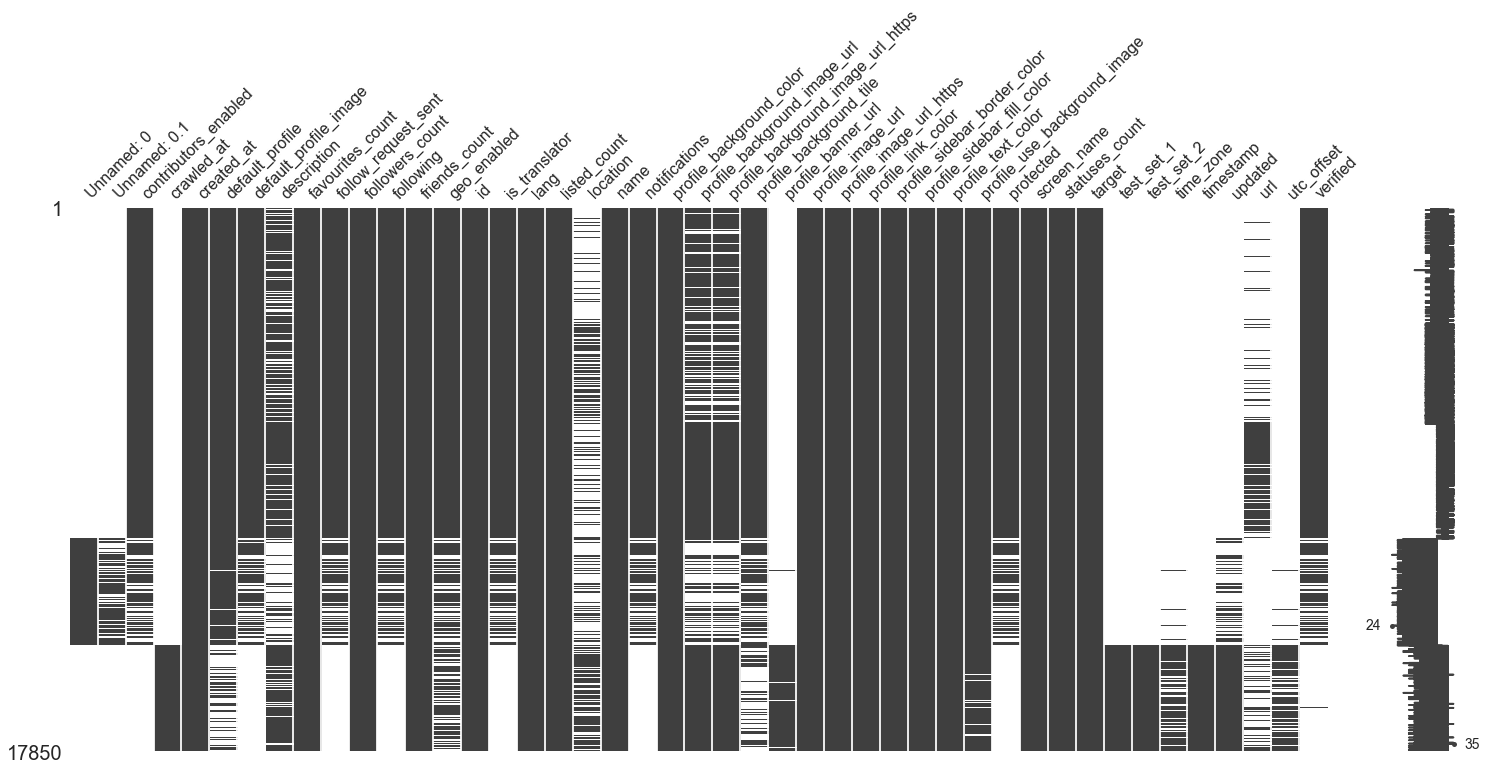

In [3]:
msno.matrix(users)

### Porn Bots

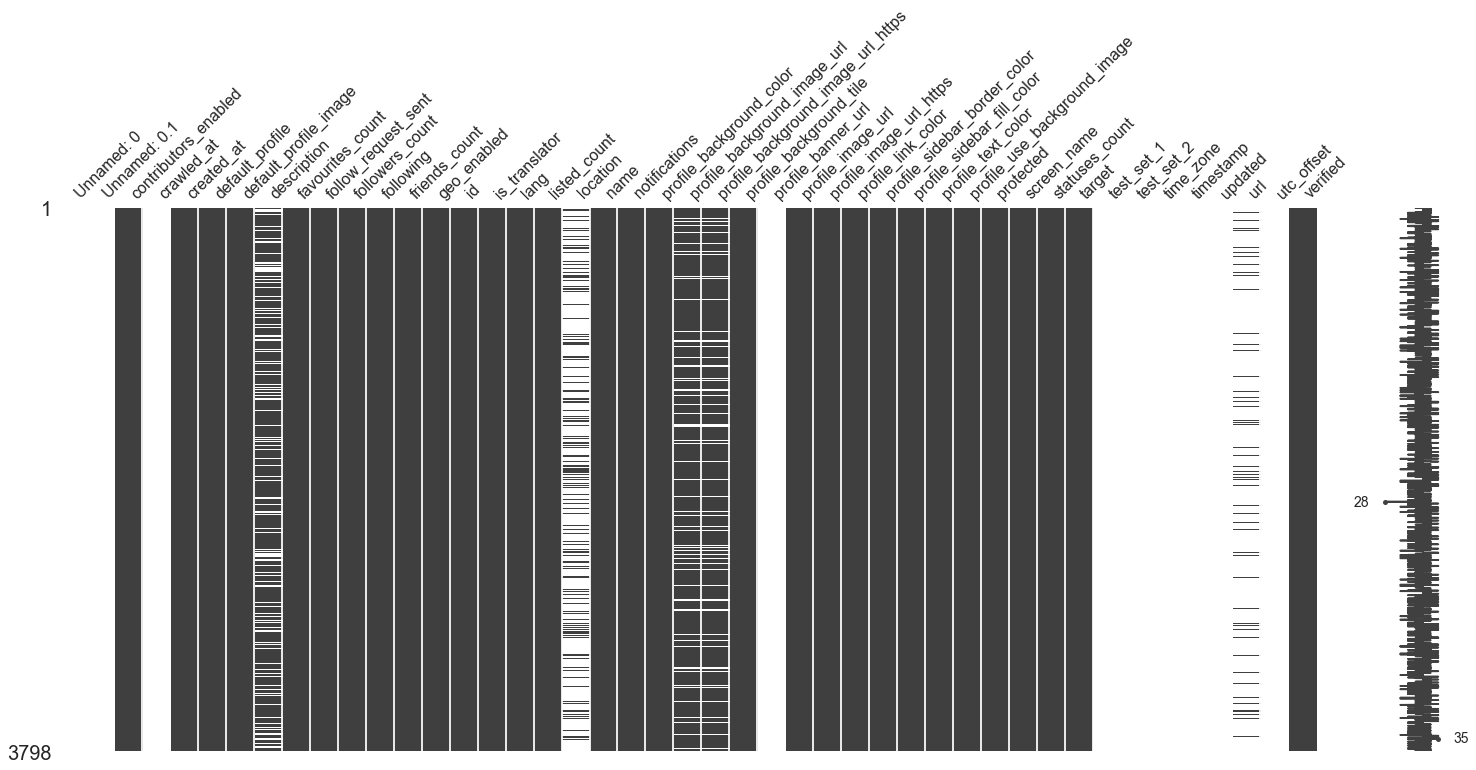

In [4]:
msno.matrix(users[users.target==0])

### Propaganda Bots

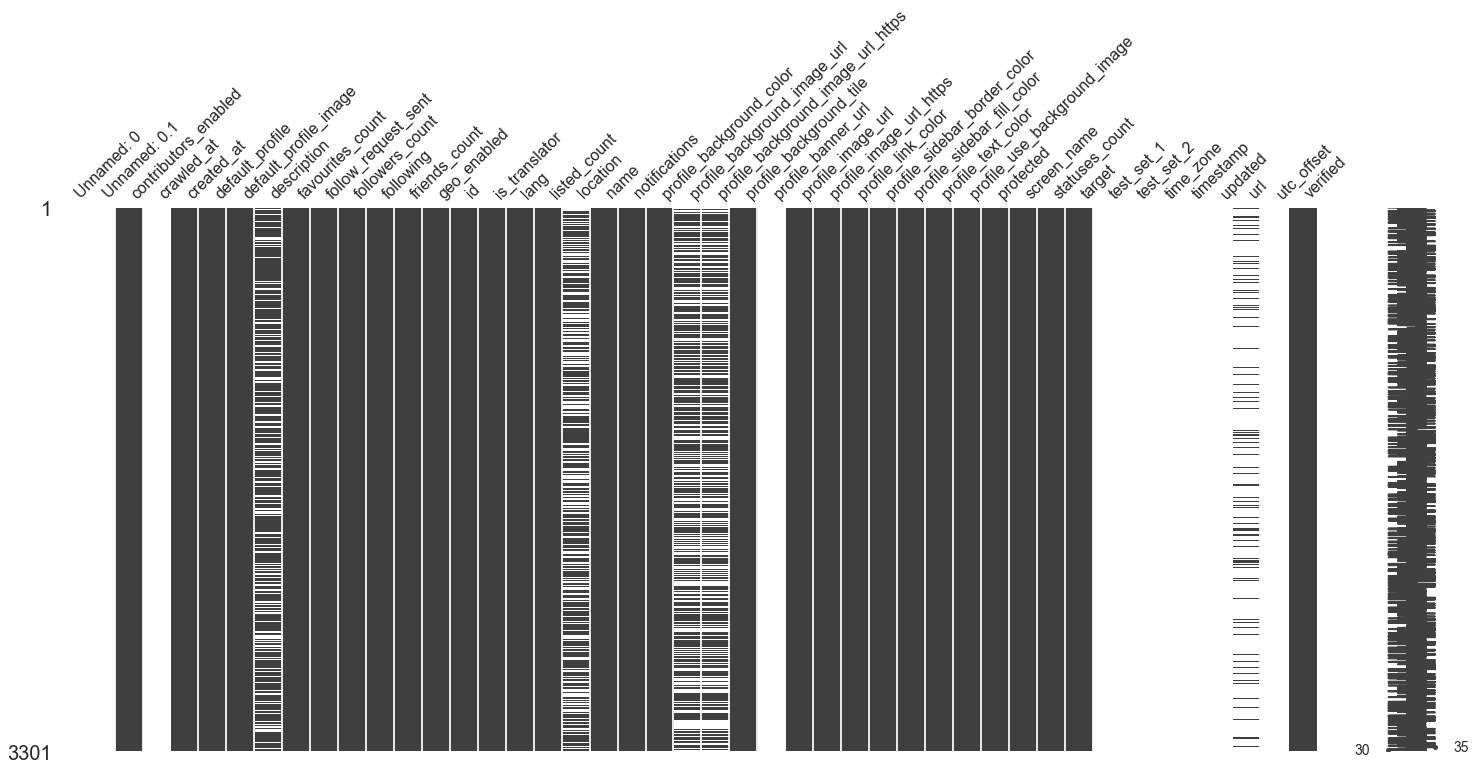

In [5]:
msno.matrix(users[users.target==1])

### Spam Bots

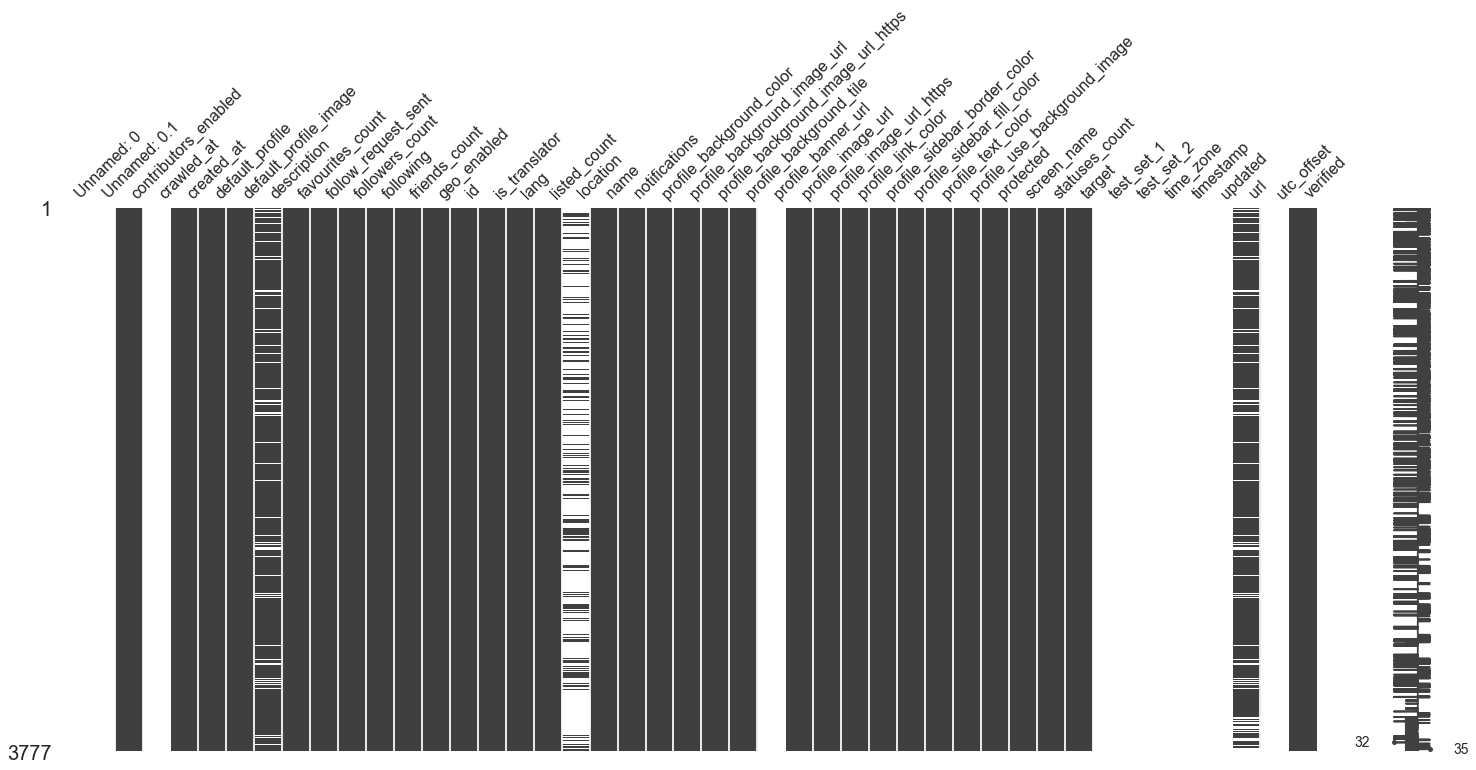

In [6]:
msno.matrix(users[users.target==2])

### Fake Followers

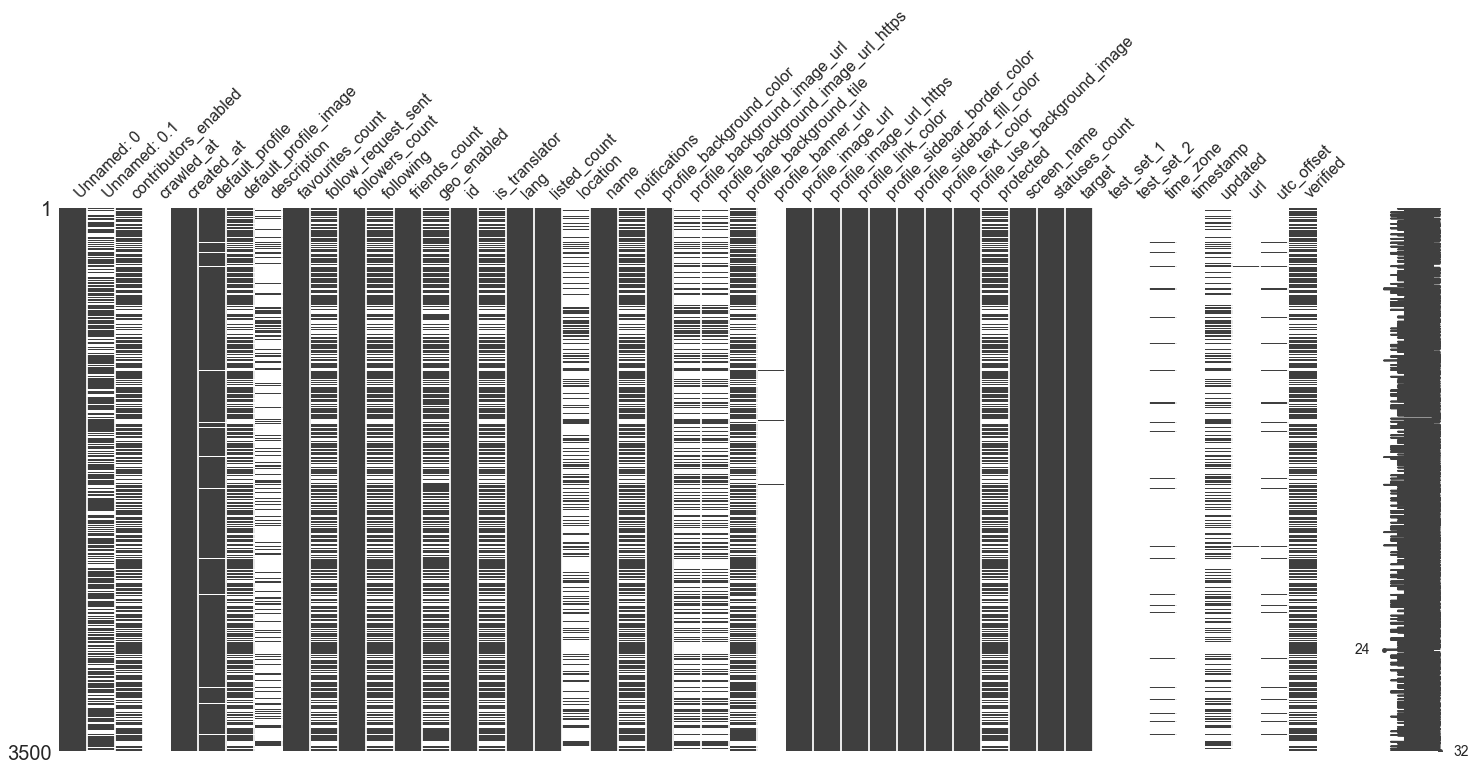

In [7]:
msno.matrix(users[users.target==3])

### Genuine Accounts

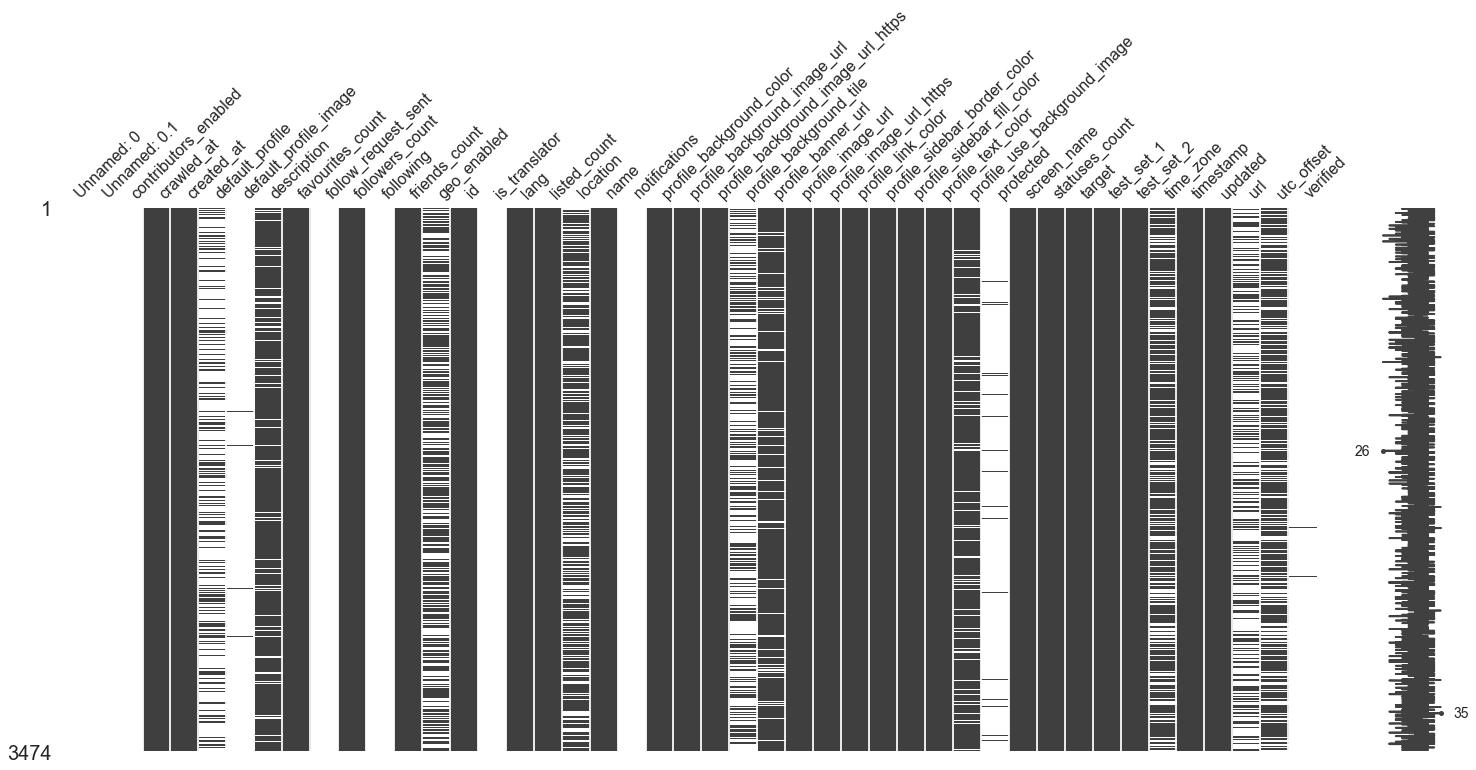

In [8]:
msno.matrix(users[users.target==4])

### remove attributes with a lot of missing values 

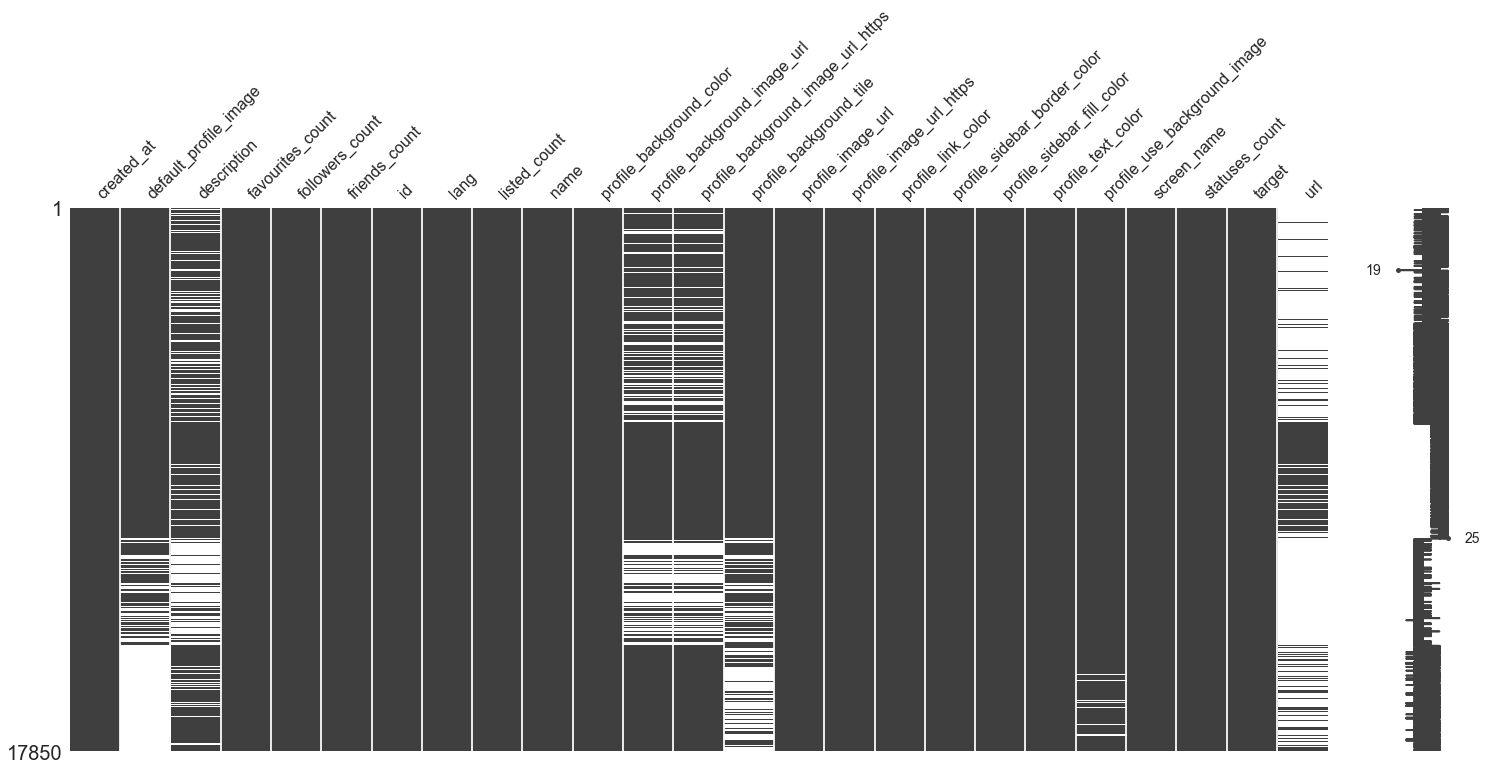

In [9]:
users = users.drop(columns=['default_profile', 'location', 'verified', 'Unnamed: 0', 'Unnamed: 0.1', 'contributors_enabled', 'crawled_at', 'follow_request_sent', 'following', 'geo_enabled', 'is_translator', 'notifications', 'profile_banner_url', 'test_set_1', 'test_set_2', 'time_zone', 'timestamp', 'updated', 'utc_offset', 'protected'], axis=1)
msno.matrix(users)

### Remove useless attributes

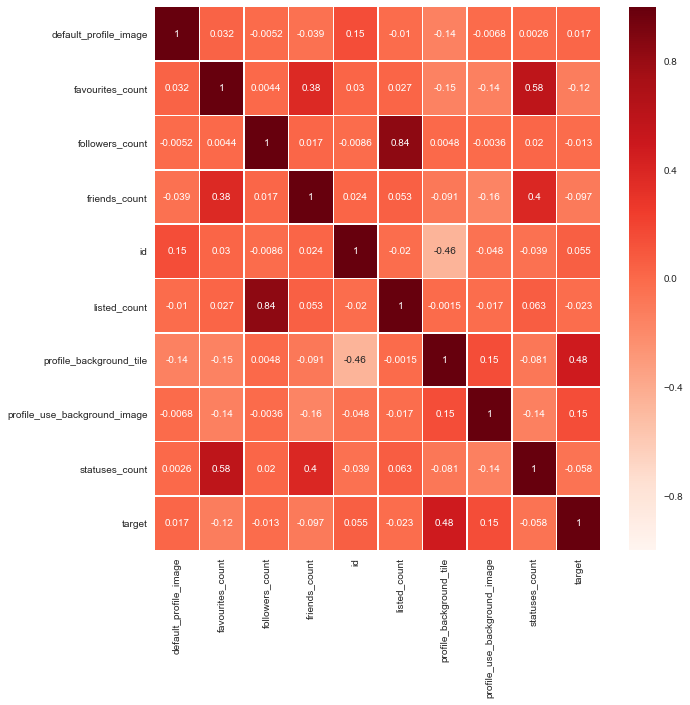

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
cov=users.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Reds",linewidths=.5, ax=ax)

In [15]:
users = users.drop(columns=['id', 'screen_name'], axis=1)

### Fill missing fields

Distribution of missing values

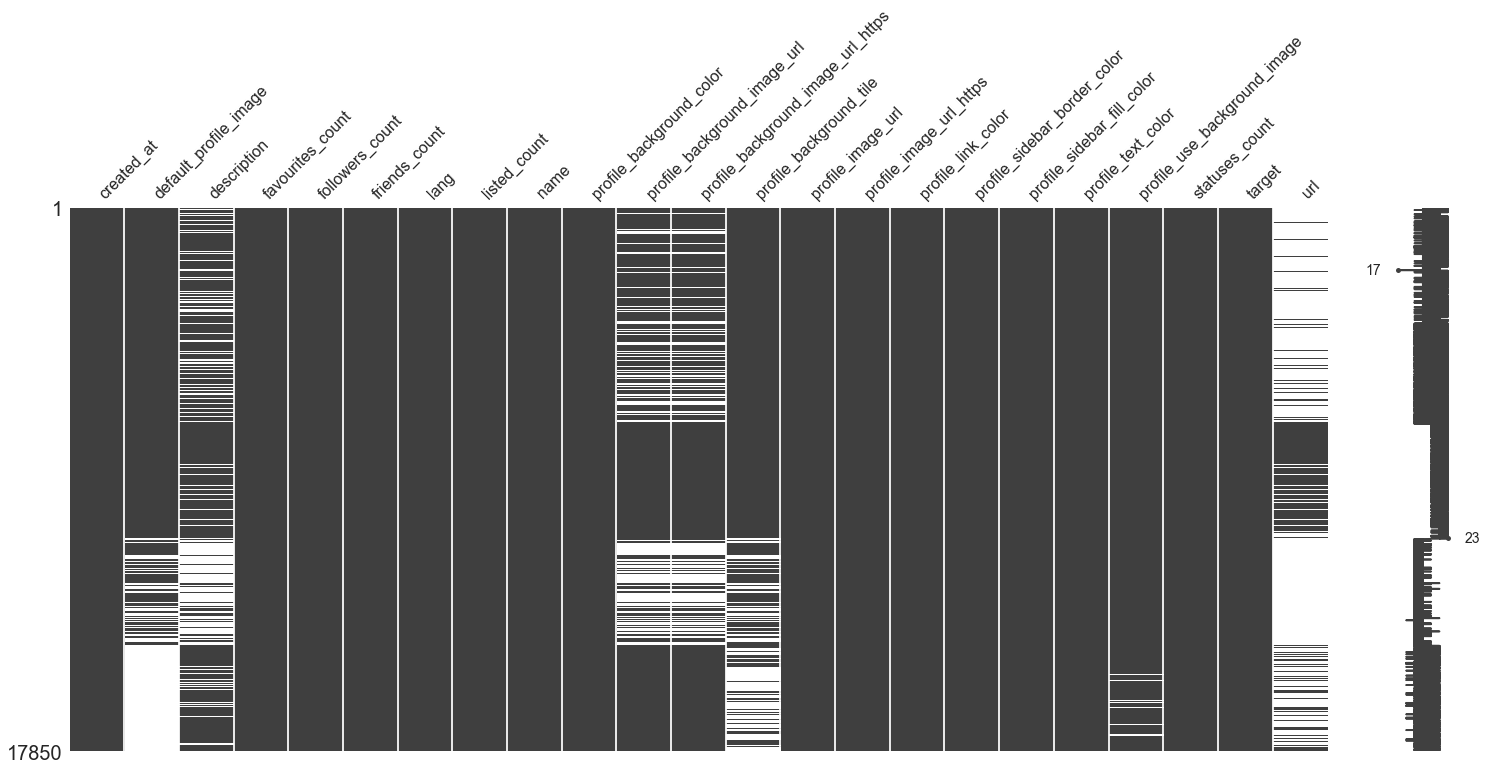

In [16]:
msno.matrix(users)

Fill missing values

In [17]:
users[users.target==2]['default_profile_image'].value_counts()

0.0    3777
Name: default_profile_image, dtype: int64

In [18]:
users['default_profile_image'] = users['default_profile_image'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [19]:
users['description'] = users['description'].fillna('')

In [20]:
users['description'] = users['description'].apply(lambda x: len(x))

In [21]:
users[users.target==2]['description'].value_counts()[:10]

0      292
160     67
159     60
158     58
55      51
86      49
89      47
157     47
50      45
64      41
Name: description, dtype: int64

In [22]:
users['lang'].isnull().values.any()

False

In [23]:
users['profile_background_color'].isnull().values.any()

False

In [24]:
users['profile_background_color'].isnull().values.any()

False

In [28]:
users['profile_background_tile'].isnull().values.any()

False

In [29]:
users['profile_background_tile'] = users['profile_background_tile'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [30]:
users['profile_background_tile'].count()

17850

In [31]:
users['profile_link_color'].isnull().values.any()

False

In [32]:
users['profile_sidebar_border_color'].isnull().values.any()

False

In [33]:
users['profile_sidebar_fill_color'].isnull().values.any()

False

In [34]:
users['profile_text_color'].isnull().values.any()

False

In [46]:
users['profile_use_background_image'].isnull().values.any()

False

In [36]:
users[users.target==2]['profile_use_background_image'].value_counts()

1.0    3769
0.0       8
Name: profile_use_background_image, dtype: int64

In [37]:
users['profile_use_background_image'] = users['profile_use_background_image'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [41]:
users['profile_background_image_url'].isnull().values.any()

False

In [42]:
users['profile_background_image_url'] = users['profile_background_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [45]:
users['profile_background_image_url_https'].isnull().values.any()

False

In [44]:
users['profile_background_image_url_https'] = users['profile_background_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [54]:
users['url'].isnull().values.any()

False

In [50]:
users['url'] = users['url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [63]:
users['profile_image_url'].isnull().values.any()

False

In [62]:
users['profile_image_url'] = users['profile_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [65]:
users['profile_image_url_https'].isnull().values.any()

False

In [64]:
users['profile_image_url_https'] = users['profile_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [61]:
users['name'].isnull().values.any()

True

In [66]:
users['name'] = users['name'].fillna('')

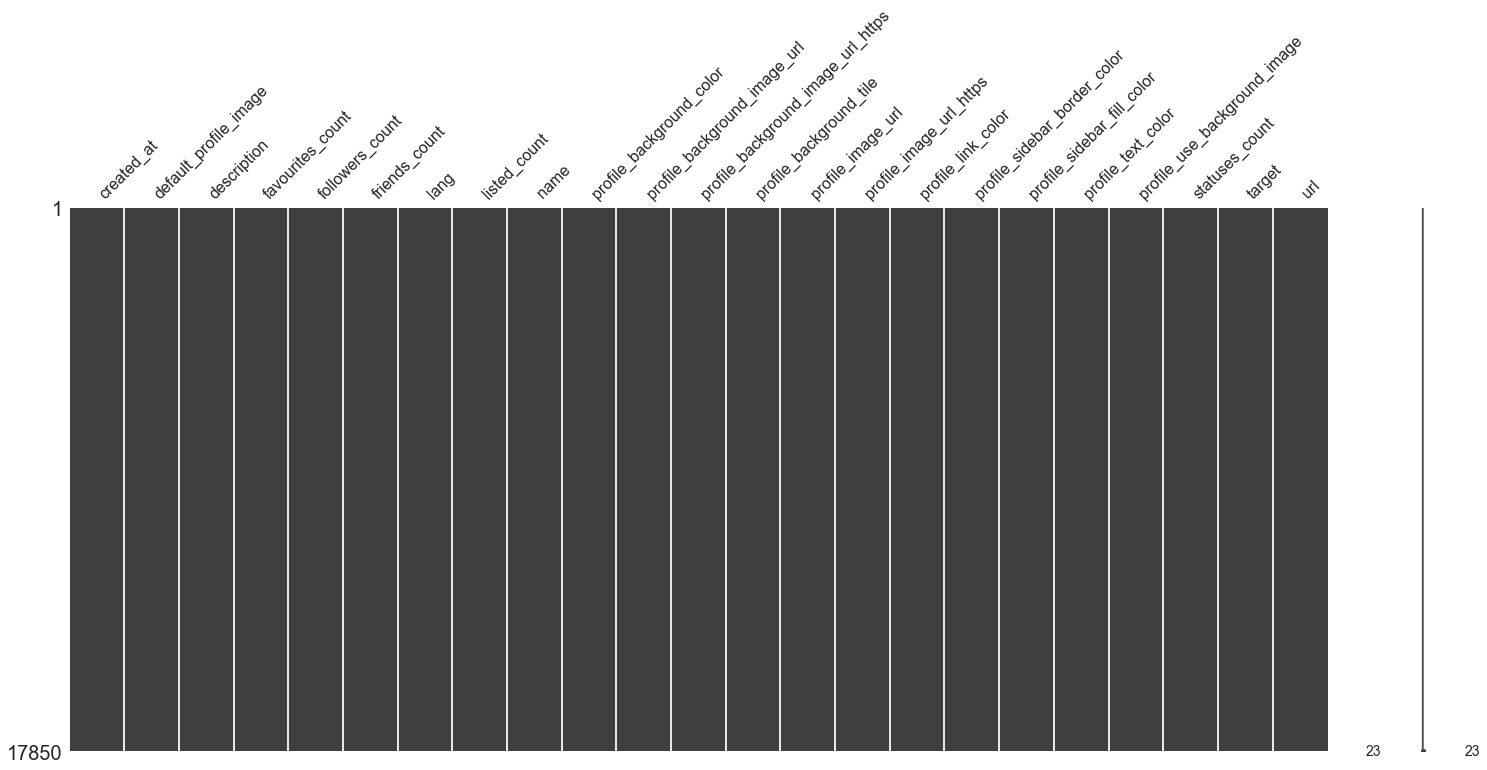

In [67]:
msno.matrix(users)

In [68]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_image_url_https,profile_use_background_image,statuses_count,target,url
count,17850.000000,17850.000000,17850.000000,1.785000e+04,17850.000000,17850.000000,17850.0,17850.000000,17850.0,17850.000000,17850.000000,17850.000000,1.785000e+04,17850.000000,17850.0
mean,0.730644,58.152941,8291.411261,8.975514e+03,1362.091653,49.291261,1.0,0.791317,1.0,0.999944,0.999944,0.977871,1.502993e+04,1.974846,1.0
std,0.443638,52.910227,30883.850770,4.324698e+05,5169.736323,1081.102403,0.0,0.406379,0.0,0.007485,0.007485,0.147107,4.888464e+04,1.417769,0.0
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.0
25%,0.000000,0.000000,0.000000,1.300000e+01,168.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,3.200000e+01,1.000000,1.0
50%,1.000000,48.000000,124.000000,3.900000e+01,236.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.170000e+02,2.000000,1.0
75%,1.000000,98.000000,1466.000000,3.517500e+02,748.750000,2.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,8.566250e+03,3.000000,1.0
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.418488e+06,4.000000,1.0


In [69]:
users.describe(exclude=[np.number])

,created_at,lang,name,profile_background_color,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color
count,17850,17850,17850,17850,17850,17850,17850,17850
unique,17395,44,17090,709,1145,285,511,526
top,2018-06-05 19:43:04,en,.,C0DEED,1DA1F2,C0DEED,DDEEF6,333333
freq,3,14358,6,10106,7897,10472,14354,15479


### Create model

### Drop non numeric features

In [70]:
users = users.drop(columns=['created_at', 'lang', 'name', 'profile_background_color', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color'], axis=1)

In [71]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,17850.000000,17850.000000,17850.000000,1.785000e+04,17850.000000,17850.000000,17850.0,17850.000000,17850.0,17850.000000,1.785000e+04,17850.000000,17850.0
mean,0.730644,58.152941,8291.411261,8.975514e+03,1362.091653,49.291261,1.0,0.791317,1.0,0.977871,1.502993e+04,1.974846,1.0
std,0.443638,52.910227,30883.850770,4.324698e+05,5169.736323,1081.102403,0.0,0.406379,0.0,0.147107,4.888464e+04,1.417769,0.0
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000e+00,0.000000,1.0
25%,0.000000,0.000000,0.000000,1.300000e+01,168.000000,0.000000,1.0,1.000000,1.0,1.000000,3.200000e+01,1.000000,1.0
50%,1.000000,48.000000,124.000000,3.900000e+01,236.000000,0.000000,1.0,1.000000,1.0,1.000000,1.170000e+02,2.000000,1.0
75%,1.000000,98.000000,1466.000000,3.517500e+02,748.750000,2.000000,1.0,1.000000,1.0,1.000000,8.566250e+03,3.000000,1.0
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.0,1.000000,1.0,1.000000,1.418488e+06,4.000000,1.0


In [72]:
target = 'target'
features = users.columns[users.columns!=target]

In [73]:
X = users[features]
y = users[target]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [79]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [80]:
# Fitting Logistic Regression
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Holdout score - forest

In [81]:
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1    2    3    4
Actual Target                            
0                 922   12    1    0    2
1                  20  791    9    1    0
2                   4   19  953    0    0
3                   1    1    0  881    5
4                   1    1    1    5  833


### Most important features

In [82]:
sorted(zip(map(lambda x: round(x, 2), forest.feature_importances_), X.columns), reverse=True)[:10]

[(0.39000000000000001, 'favourites_count'),
 (0.23000000000000001, 'default_profile_image'),
 (0.19, 'statuses_count'),
 (0.089999999999999997, 'followers_count'),
 (0.040000000000000001, 'friends_count'),
 (0.029999999999999999, 'profile_background_image_url_https'),
 (0.02, 'description'),
 (0.01, 'listed_count'),
 (0.0, 'url'),
 (0.0, 'profile_use_background_image')]

### Holdout score - logistic regression

In [83]:
# Predicting the Test set results
y_pred = logreg.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1    2    3    4
Actual Target                            
0                 772    4   68   14   79
1                  38  593   51    1  138
2                  42   17  910    0    7
3                   1    0   99  783    5
4                  73  118  130    1  519


## KNN

In [84]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [85]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [86]:
# Predicting the Test set results
y_pred = knn.predict(X_test_n)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1    2    3    4
Actual Target                            
0                 737    9  184    7    0
1                  34  746   37    4    0
2                 158   30  788    0    0
3                   1    1    1  798   87
4                   1    1    1   83  755


## Cross Validation scores

In [87]:
from sklearn.model_selection import cross_val_score
logreg = linear_model.LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=10)
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1_macro').mean())

In [88]:
## Random forest  /  Logistic Regression  /  KNN
scores

[0.98015997103044383, 0.78541225416214633, 0.88948072011792512]